In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from pathlib import Path

ZIP_PATH = Path("/content/drive/MyDrive/Semester 7/Dataset/archive flowers.zip")  # sesuaikan kalau beda lokasi
EXTRACT_DIR = Path("/content/data_flowers")

EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)

print("Extracted to:", EXTRACT_DIR)


Extracted to: /content/data_flowers


In [ ]:
from pathlib import Path

ROOT = Path("/content/data_flowers/archive/flowers")  # kalau beda, cek print di bawah
# Kalau kamu gak yakin foldernya, cari otomatis:

def find_flowers_root(base="/content/data_flowers"):
    base = Path(base)
    for p in base.rglob("flowers"):
        if p.is_dir():
            # cek apakah ada 5 kelas
            sub = [x.name for x in p.iterdir() if x.is_dir()]
            if set(sub) >= {"daisy","dandelion","rose","sunflower","tulip"}:
                return p
    return None

auto_root = find_flowers_root()
print("Auto ROOT:", auto_root)
ROOT = auto_root if auto_root is not None else ROOT
print("Final ROOT:", ROOT)
print([p.name for p in ROOT.iterdir() if p.is_dir()])


Auto ROOT: /content/data_flowers/flowers
Final ROOT: /content/data_flowers/flowers
['sunflower', 'rose', 'daisy', 'tulip', 'dandelion']


# EDA

In [ ]:
# Hitung jumlah gambar per kelas
import pandas as pd

class_names = sorted([p.name for p in ROOT.iterdir() if p.is_dir()])
counts = {}
for c in class_names:
    counts[c] = len(list((ROOT/c).glob("*.*")))

df_counts = pd.DataFrame({"class": list(counts.keys()), "count": list(counts.values())})
df_counts["pct"] = (df_counts["count"] / df_counts["count"].sum() * 100).round(2)

df_counts, df_counts["count"].sum()


(       class  count    pct
 0      daisy    764  17.70
 1  dandelion   1052  24.37
 2       rose    784  18.16
 3  sunflower    733  16.98
 4      tulip    984  22.79,
 np.int64(4317))

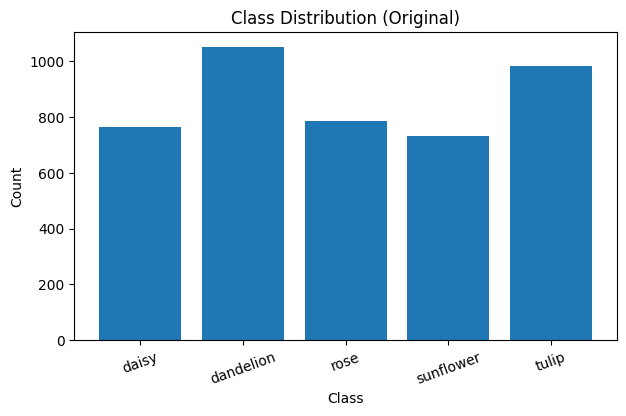

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(df_counts["class"], df_counts["count"])
plt.title("Class Distribution (Original)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.show()


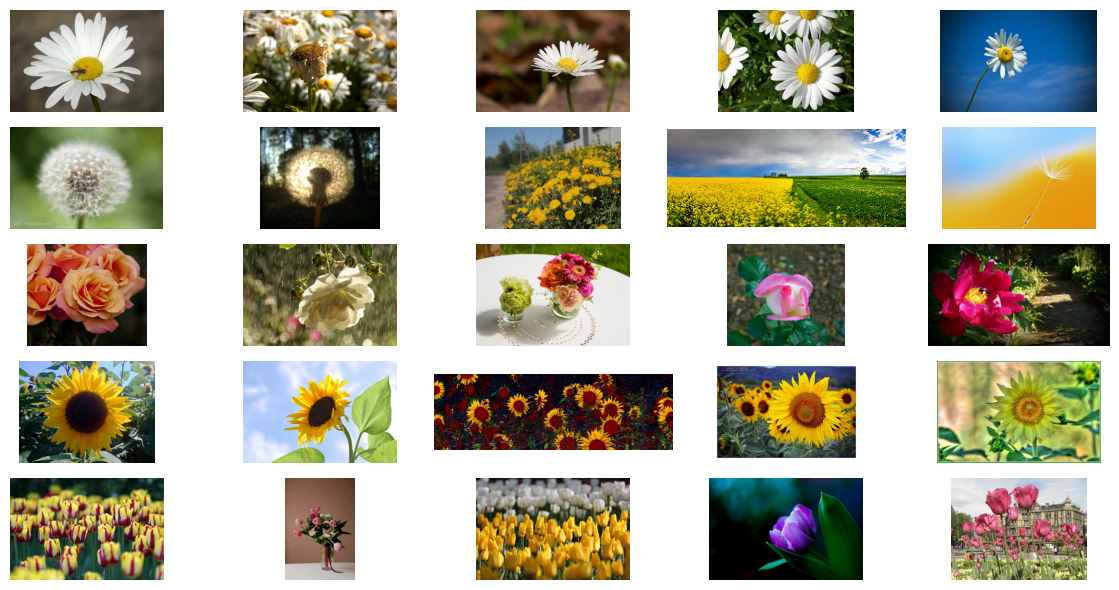

In [ ]:
import random
from PIL import Image

plt.figure(figsize=(12,6))
k = 5  # jumlah contoh per kelas
idx = 1

for c in class_names:
    files = list((ROOT/c).glob("*.*"))
    picks = random.sample(files, k=min(k, len(files)))
    for fp in picks:
        img = Image.open(fp).convert("RGB")
        plt.subplot(len(class_names), k, idx)
        plt.imshow(img)
        plt.axis("off")
        if idx % k == 1:
            plt.ylabel(c, rotation=0, labelpad=40, va="center")
        idx += 1

plt.tight_layout()
plt.show()


# PREPROCESSING

FOLDER BARU AUGMENTASI

In [ ]:
# Buat folder output dataset "flowers_5000" ===
import shutil
from pathlib import Path

OUT_ROOT = Path("/content/flowers_5000")
if OUT_ROOT.exists():
    shutil.rmtree(OUT_ROOT)
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# copy original data dulu
for c in class_names:
    (OUT_ROOT/c).mkdir(parents=True, exist_ok=True)
    for fp in (ROOT/c).glob("*.*"):
        shutil.copy(fp, OUT_ROOT/c/fp.name)

print("Copied originals to:", OUT_ROOT)


Copied originals to: /content/flowers_5000


AUGMENTASI


In [ ]:
# Augmentasi offline per kelas sampai target
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# target per kelas
TARGET_PER_CLASS = 1000

aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
])

def load_img_tf(path, img_size=(224,224)):
    img = tf.io.read_file(str(path))
    img = tf.image.decode_jpeg(img, channels=3)  # jpeg/png aman biasanya
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)  # 0..255 float
    return img

def save_img_tf(img_tensor, out_path):
    img_uint8 = tf.clip_by_value(img_tensor, 0, 255)
    img_uint8 = tf.cast(img_uint8, tf.uint8)
    keras.utils.save_img(str(out_path), img_uint8)

added_total = 0
for c in class_names:
    cur_files = list((OUT_ROOT/c).glob("*.*"))
    cur_n = len(cur_files)
    need = max(0, TARGET_PER_CLASS - cur_n)
    if need == 0:
        print(f"{c}: {cur_n} (skip augment)")
        continue

    print(f"{c}: {cur_n} -> add {need}")
    src_files = list((ROOT/c).glob("*.*"))
    for i in range(need):
        fp = random.choice(src_files)
        x = load_img_tf(fp, (224,224))
        x = tf.expand_dims(x, 0)            # (1,H,W,3)
        x_aug = aug(x, training=True)[0]    # (H,W,3)

        out_name = f"aug_{i:05d}_{Path(fp).stem}.jpg"
        save_img_tf(x_aug, OUT_ROOT/c/out_name)
        added_total += 1

print("Total augmented images added:", added_total)

daisy: 764 -> add 236
dandelion: 1052 (skip augment)
rose: 784 -> add 216
sunflower: 733 -> add 267
tulip: 984 -> add 16
Total augmented images added: 735


In [ ]:
# Verifikasi jumlah akhir (harus >= 5000) ===
final_counts = {}
for c in class_names:
    final_counts[c] = len(list((OUT_ROOT/c).glob("*.*")))

df_final = pd.DataFrame({"class": list(final_counts.keys()), "count": list(final_counts.values())})
df_final, df_final["count"].sum()


(       class  count
 0      daisy   1000
 1  dandelion   1052
 2       rose   1000
 3  sunflower   1000
 4      tulip   1000,
 np.int64(5052))

SPLIT DATA

In [ ]:
# Buat list path + label, lalu split stratified
from sklearn.model_selection import train_test_split
import numpy as np

all_paths = []
all_labels = []

class_to_idx = {c:i for i,c in enumerate(class_names)}

for c in class_names:
    for fp in (OUT_ROOT/c).glob("*.*"):
        all_paths.append(str(fp))
        all_labels.append(class_to_idx[c])

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.30, random_state=42, stratify=all_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(3536, 758, 758)

PROCESSING PIPELINE

In [ ]:
# Dataset pipeline
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)  # 0..255
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(decode_resize, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_test, y_test, training=False)

# cek 1 batch
for xb, yb in train_ds.take(1):
    print(xb.shape, yb.shape, xb.dtype)


(32, 224, 224, 3) (32,) <dtype: 'float32'>


# CNN SCRATCH

In [ ]:
# Model
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(class_names)

def build_scratch_cnn(input_shape=(224,224,3), num_classes=5):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.20)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.30)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="ScratchCNN")

scratch_model = build_scratch_cnn(num_classes=NUM_CLASSES)
scratch_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
scratch_model.summary()


Model: "ScratchCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,597 (1.49 MB)

 Trainable params: 390,149 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Model
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(class_names)

def build_scratch_cnn(input_shape=(224,224,3), num_classes=5):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.20)(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.30)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="ScratchCNN")

scratch_model = build_scratch_cnn(num_classes=NUM_CLASSES)
scratch_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
scratch_model.summary()


Model: "ScratchCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,597 (1.49 MB)

 Trainable params: 390,149 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train Scratch CNN
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

hist_scratch = scratch_model.fit(
    train_ds, validation_data=val_ds,
    epochs=20, callbacks=callbacks
)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 738s 7s/step - accuracy: 0.4772 - loss: 1.2352 - val_accuracy: 0.2111 - val_loss: 2.0357 - learning_rate: 0.0010
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 760s 7s/step - accuracy: 0.5074 - loss: 1.1879 - val_accuracy: 0.2309 - val_loss: 2.1627 - learning_rate: 0.0010
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 747s 6s/step - accuracy: 0.5423 - loss: 1.1278 - val_accuracy: 0.3206 - val_loss: 1.5611 - learning_rate: 0.0010
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 750s 6s/step - accuracy: 0.5851 - loss: 1.0640 - val_accuracy: 0.5567 - val_loss: 1.0792 - learning_rate: 0.0010
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 736s 6s/step - accuracy: 0.6135 - loss: 1.0314 - val_accuracy: 0.4802 - val_loss: 1.2148 - learning_rate: 0.0010
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 745s 6s/step - accuracy: 0.5905 - loss: 1.0384 - val_accuracy: 0.5290 - val_loss: 1.1876 - learning_rate: 0.0010
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 701s 6s/step - accuracy: 0.6540 - loss: 0.

GRAFIK LOSS & ACC

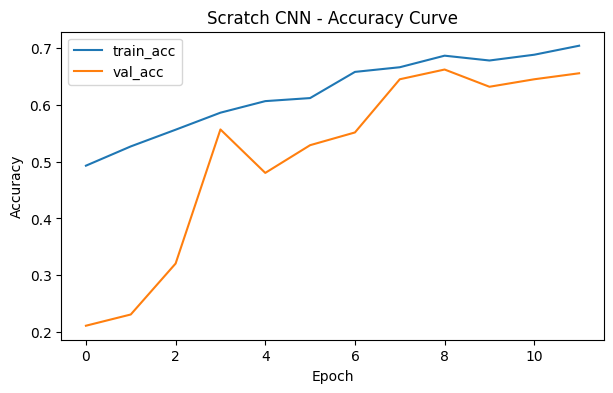

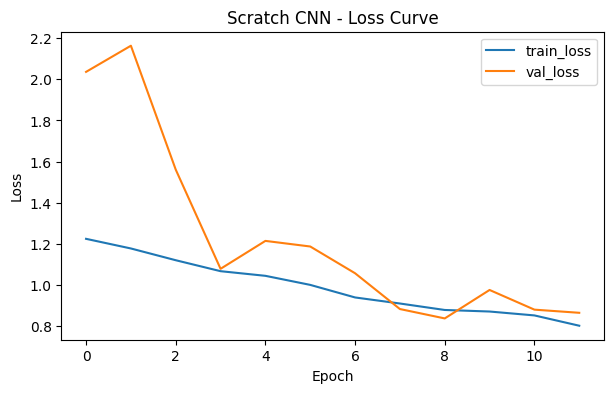

24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6632 - loss: 0.9031
Scratch CNN - Test Loss: 0.8855727910995483
Scratch CNN - Test Acc : 0.6662269234657288


In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(7,4))
plt.plot(hist_scratch.history["accuracy"], label="train_acc")
plt.plot(hist_scratch.history["val_accuracy"], label="val_acc")
plt.title("Scratch CNN - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(7,4))
plt.plot(hist_scratch.history["loss"], label="train_loss")
plt.plot(hist_scratch.history["val_loss"], label="val_loss")
plt.title("Scratch CNN - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_acc = scratch_model.evaluate(test_ds, verbose=1)
print("Scratch CNN - Test Loss:", test_loss)
print("Scratch CNN - Test Acc :", test_acc)

CR & CM

=== Scratch CNN - Classification Report ===
              precision    recall  f1-score   support

       daisy     0.7153    0.6533    0.6829       150
   dandelion     0.6197    0.8354    0.7116       158
        rose     0.5635    0.7400    0.6398       150
   sunflower     0.7255    0.7400    0.7327       150
       tulip     0.9138    0.3533    0.5096       150

    accuracy                         0.6662       758
   macro avg     0.7076    0.6644    0.6553       758
weighted avg     0.7066    0.6662    0.6559       758



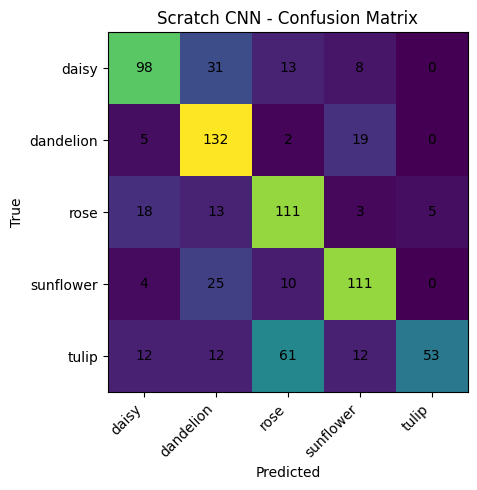

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# kumpulkan y_true & y_pred dari test_ds
y_true = []
y_pred = []

for xb, yb in test_ds:
    prob = scratch_model.predict(xb, verbose=0)
    pred = np.argmax(prob, axis=1)
    y_true.extend(yb.numpy())
    y_pred.extend(pred)

# classification report
print("=== Scratch CNN - Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Scratch CNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path

SAVE_DIR = Path("/content/drive/MyDrive/Semester 7/Dataset")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

scratch_model.save(SAVE_DIR/"scratch_cnn.keras")
print("Saved:", SAVE_DIR/"scratch_cnn.keras")


Saved: /content/drive/MyDrive/sEMESTER 7/Dataset/uap_flowers_models/scratch_cnn.keras


# EFFICIENTNET-B0 + FREEZE

FREEZE

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

NUM_CLASSES = len(class_names)
INPUT_SHAPE = (224, 224, 3)

def build_effnetb0_freeze(num_classes=5, input_shape=(224,224,3), dropout=0.30):
    inputs = keras.Input(shape=input_shape)

    # EfficientNet expects preprocess_input
    x = eff_preprocess(inputs)  # input 0..255 float -> OK

    base = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base.trainable = False  # ✅ FREEZE

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="EfficientNetB0_Freeze")
    return model, base

eff_model, eff_base = build_effnetb0_freeze(NUM_CLASSES, INPUT_SHAPE, dropout=0.30)

eff_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

eff_model.summary()

Model: "EfficientNetB0_Freeze"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_5[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_6[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

hist_eff_freeze = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.6024 - loss: 1.0510 - val_accuracy: 0.8694 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.8761 - loss: 0.4062 - val_accuracy: 0.8971 - val_loss: 0.3223 - learning_rate: 0.0010
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8978 - loss: 0.3209 - val_accuracy: 0.9103 - val_loss: 0.2793 - learning_rate: 0.0010
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.9087 - loss: 0.2732 - val_accuracy: 0.9208 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.9173 - loss: 0.2500 - val_accuracy: 0.9195 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.9271 - loss: 0.2304 - val_accuracy: 0.9208 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 7/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.9332 - loss: 0.

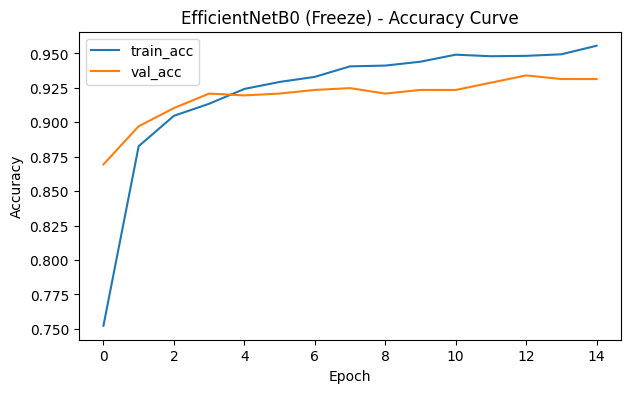

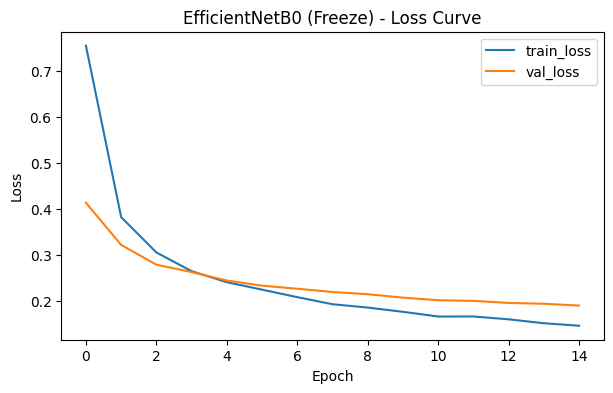

24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9283 - loss: 0.2207
EfficientNetB0 (Freeze) - Test Loss: 0.2034456431865692
EfficientNetB0 (Freeze) - Test Acc : 0.9300791621208191


In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(7,4))
plt.plot(hist_eff_freeze.history["accuracy"], label="train_acc")
plt.plot(hist_eff_freeze.history["val_accuracy"], label="val_acc")
plt.title("EfficientNetB0 (Freeze) - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(7,4))
plt.plot(hist_eff_freeze.history["loss"], label="train_loss")
plt.plot(hist_eff_freeze.history["val_loss"], label="val_loss")
plt.title("EfficientNetB0 (Freeze) - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
test_loss, test_acc = eff_model.evaluate(test_ds, verbose=1)
print("EfficientNetB0 (Freeze) - Test Loss:", test_loss)
print("EfficientNetB0 (Freeze) - Test Acc :", test_acc)


=== EfficientNetB0 (Freeze) - Classification Report ===
              precision    recall  f1-score   support

       daisy     0.9658    0.9400    0.9527       150
   dandelion     0.9557    0.9557    0.9557       158
        rose     0.9085    0.9267    0.9175       150
   sunflower     0.9068    0.9733    0.9389       150
       tulip     0.9143    0.8533    0.8828       150

    accuracy                         0.9301       758
   macro avg     0.9302    0.9298    0.9295       758
weighted avg     0.9305    0.9301    0.9298       758



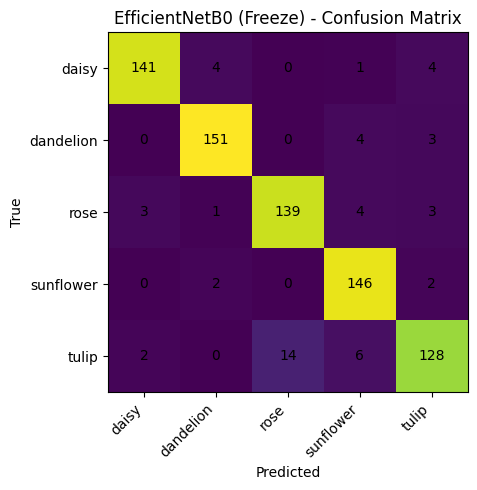

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for xb, yb in test_ds:
    probs = eff_model.predict(xb, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(preds.tolist())

print("=== EfficientNetB0 (Freeze) - Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("EfficientNetB0 (Freeze) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [ ]:
SAVE_DIR = Path("/content/drive/MyDrive/Semester 7/Dataset")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

eff_model.save(SAVE_DIR/"efficientnetb0_freeze.keras")
print("Saved:", SAVE_DIR/"efficientnetb0_freeze.keras")

Saved: /content/drive/MyDrive/Semester 7/Dataset/efficientnetb0_freeze.keras


# EFFICIENTNET-B0 + FINE TUNING

FT2

In [ ]:
from tensorflow.keras import layers

# aktifkan backbone untuk fine-tune
eff_base.trainable = True

# freeze BatchNorm supaya training stabil
for layer in eff_base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# buka hanya layer atas (last N)
N = 40
for layer in eff_base.layers[:-N]:
    layer.trainable = False

# compile ulang dengan LR kecil
eff_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Backbone layers:", len(eff_base.layers))
print("Trainable backbone layers:", sum(l.trainable for l in eff_base.layers))


Backbone layers: 238
Trainable backbone layers: 32


In [ ]:
callbacks_ft2 = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

hist_eff_ft2 = eff_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_ft2
)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.2251 - loss: 1.6946 - val_accuracy: 0.5765 - val_loss: 1.2620 - learning_rate: 1.0000e-05
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.5775 - loss: 1.1906 - val_accuracy: 0.7836 - val_loss: 0.8190 - learning_rate: 1.0000e-05
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - accuracy: 0.7295 - loss: 0.8237 - val_accuracy: 0.8325 - val_loss: 0.5515 - learning_rate: 1.0000e-05
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.8044 - loss: 0.5927 - val_accuracy: 0.8681 - val_loss: 0.4164 - learning_rate: 1.0000e-05
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8370 - loss: 0.4686 - val_accuracy: 0.8958 - val_loss: 0.3471 - learning_rate: 1.0000e-05
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.8593 - loss: 0.3979 - val_accuracy: 0.9116 - val_loss: 0.3021 - learning_rate: 1.0000e-05
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - acc

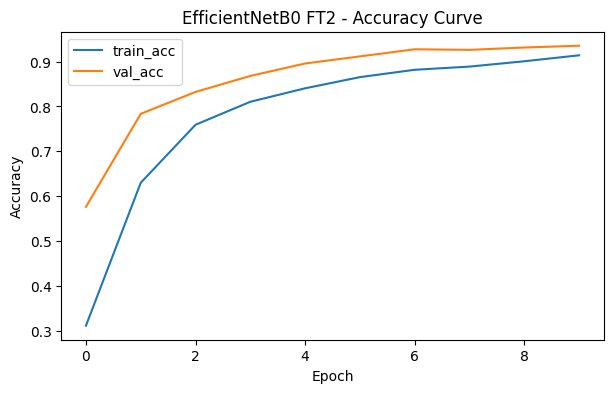

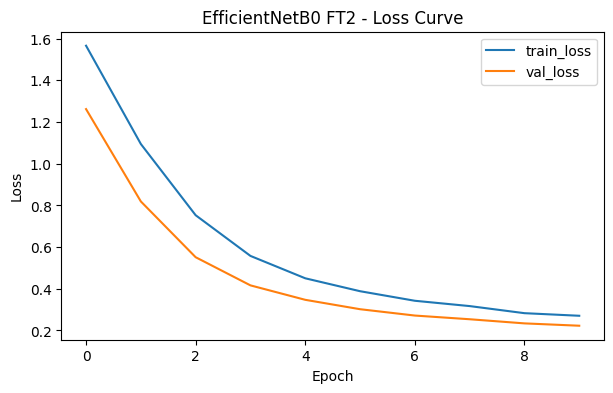

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(hist_eff_ft2.history["accuracy"], label="train_acc")
plt.plot(hist_eff_ft2.history["val_accuracy"], label="val_acc")
plt.title("EfficientNetB0 FT2 - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist_eff_ft2.history["loss"], label="train_loss")
plt.plot(hist_eff_ft2.history["val_loss"], label="val_loss")
plt.title("EfficientNetB0 FT2 - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
test_loss_ft2, test_acc_ft2 = eff_model.evaluate(test_ds, verbose=1)
print("EfficientNetB0 FT2 - Test Loss:", test_loss_ft2)
print("EfficientNetB0 FT2 - Test Acc :", test_acc_ft2)

24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9084 - loss: 0.2553
EfficientNetB0 FT2 - Test Loss: 0.23403343558311462
EfficientNetB0 FT2 - Test Acc : 0.9234828352928162


=== EfficientNetB0 FT2 - Classification Report ===
              precision    recall  f1-score   support

       daisy     0.9638    0.8867    0.9236       150
   dandelion     0.9268    0.9620    0.9441       158
        rose     0.9007    0.9067    0.9037       150
   sunflower     0.9304    0.9800    0.9545       150
       tulip     0.8980    0.8800    0.8889       150

    accuracy                         0.9235       758
   macro avg     0.9239    0.9231    0.9230       758
weighted avg     0.9240    0.9235    0.9232       758



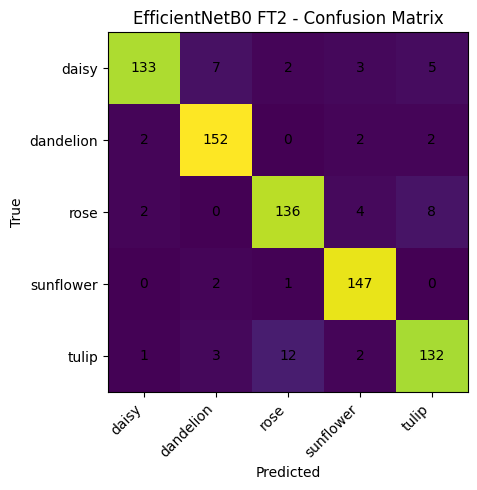

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for xb, yb in test_ds:
    probs = eff_model.predict(xb, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(preds.tolist())

print("=== EfficientNetB0 FT2 - Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("EfficientNetB0 FT2 - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path
import json

SAVE_DIR = Path("/content/drive/MyDrive/sEMESTER 7/Dataset/uap_flowers_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

eff_model.save(SAVE_DIR / "efficientnetb0_ft2.keras")

with open(SAVE_DIR / "class_names.json", "w") as f:
    json.dump(class_names, f)

with open(SAVE_DIR / "config.json", "w") as f:
    json.dump({"img_h": 224, "img_w": 224}, f)

print("Saved:", SAVE_DIR / "efficientnetb0_ft2.keras")


Saved: /content/drive/MyDrive/sEMESTER 7/Dataset/uap_flowers_models/efficientnetb0_ft2.keras


# MOBILENETV2 + FREEZE

BANGUN MOBILENETV2

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mnet_preprocess

NUM_CLASSES = len(class_names)
INPUT_SHAPE = (224, 224, 3)

def build_mobilenetv2_freeze(num_classes=5, input_shape=(224,224,3), dropout=0.30):
    inputs = keras.Input(shape=input_shape)
    x = mnet_preprocess(inputs)  # input 0..255 float -> OK

    base = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base.trainable = False  # ✅ FREEZE

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="MobileNetV2_Freeze")
    return model, base

mnet_model, mnet_base = build_mobilenetv2_freeze(NUM_CLASSES, INPUT_SHAPE, dropout=0.30)

mnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

mnet_model.summary()

/tmp/ipython-input-3160146365.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_Freeze"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

TRAIN FREEZE

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

hist_mnet_freeze = mnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5415 - loss: 1.1469 - val_accuracy: 0.8417 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8324 - loss: 0.4893 - val_accuracy: 0.8707 - val_loss: 0.3847 - learning_rate: 0.0010
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8786 - loss: 0.3666 - val_accuracy: 0.8799 - val_loss: 0.3544 - learning_rate: 0.0010
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8857 - loss: 0.3195 - val_accuracy: 0.8852 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9062 - loss: 0.2826 - val_accuracy: 0.8865 - val_loss: 0.3471 - learning_rate: 0.0010
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9067 - loss: 0.2729 - val_accuracy: 0.8945 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 7/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9180 - loss: 0.

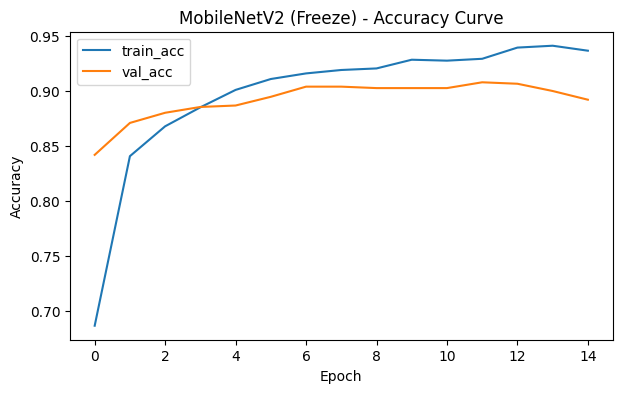

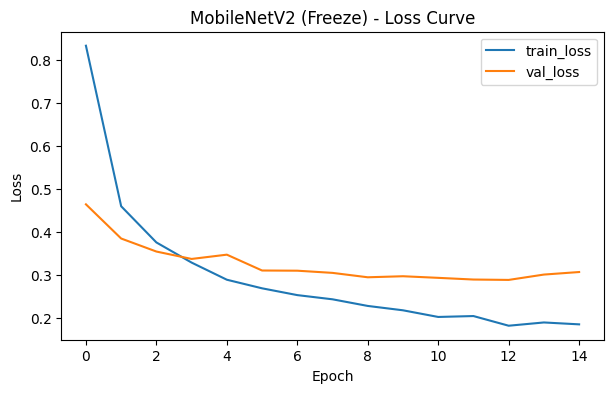

24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8880 - loss: 0.3154
MobileNetV2 (Freeze) - Test Loss: 0.3160707354545593
MobileNetV2 (Freeze) - Test Acc : 0.8931398391723633


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(hist_mnet_freeze.history["accuracy"], label="train_acc")
plt.plot(hist_mnet_freeze.history["val_accuracy"], label="val_acc")
plt.title("MobileNetV2 (Freeze) - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist_mnet_freeze.history["loss"], label="train_loss")
plt.plot(hist_mnet_freeze.history["val_loss"], label="val_loss")
plt.title("MobileNetV2 (Freeze) - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_acc = mnet_model.evaluate(test_ds, verbose=1)
print("MobileNetV2 (Freeze) - Test Loss:", test_loss)
print("MobileNetV2 (Freeze) - Test Acc :", test_acc)

=== MobileNetV2 (Freeze) - Classification Report ===
              precision    recall  f1-score   support

       daisy     0.9291    0.8733    0.9003       150
   dandelion     0.9130    0.9304    0.9216       158
        rose     0.8611    0.8267    0.8435       150
   sunflower     0.9221    0.9467    0.9342       150
       tulip     0.8418    0.8867    0.8636       150

    accuracy                         0.8931       758
   macro avg     0.8934    0.8927    0.8927       758
weighted avg     0.8936    0.8931    0.8930       758



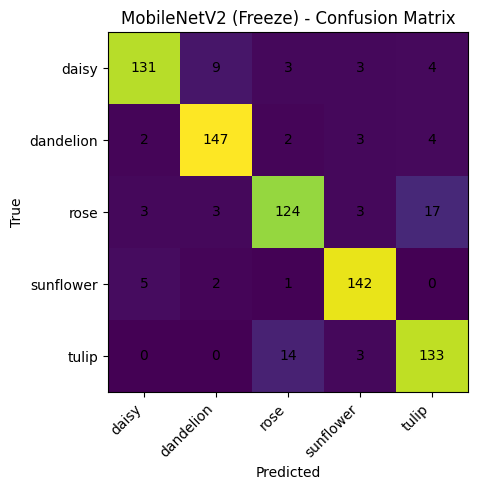

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for xb, yb in test_ds:
    probs = mnet_model.predict(xb, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(preds.tolist())

print("=== MobileNetV2 (Freeze) - Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("MobileNetV2 (Freeze) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path
import json

SAVE_DIR = Path("/content/drive/MyDrive/sEMESTER 7/Dataset/uap_flowers_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

mnet_model.save(SAVE_DIR / "mobilenetv2_freeze.keras")

# simpan artifacts untuk Streamlit
with open(SAVE_DIR / "class_names.json", "w") as f:
    json.dump(class_names, f)

with open(SAVE_DIR / "config.json", "w") as f:
    json.dump({"img_h": 224, "img_w": 224}, f)

print("Saved:", SAVE_DIR / "mobilenetv2_freeze.keras")
print("Artifacts:", [p.name for p in SAVE_DIR.iterdir()])

Saved: /content/drive/MyDrive/sEMESTER 7/Dataset/uap_flowers_models/mobilenetv2_freeze.keras
Artifacts: ['scratch_cnn.keras', 'efficientnetb0_ft2.keras', 'class_names.json', 'config.json', 'efficientnetb0_lora.keras', 'mobilenetv2_freeze.keras']


# MOBILENETV2 + FINE TUNING

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# pastikan head (Dense terakhir) trainable
mnet_model.layers[-1].trainable = True

# aktifkan backbone
mnet_base.trainable = True

# Freeze BatchNorm
for layer in mnet_base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Unfreeze last N layers
N = 30
for layer in mnet_base.layers[:-N]:
    layer.trainable = False

print("Trainable weights after FT2:", len(mnet_model.trainable_weights))


Trainable weights after FT2: 12


TRAIN FINE TUNING

In [ ]:
mnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True
)
callbacks_ft2 = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

hist_mnet_ft2 = mnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_ft2
)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 638s 6s/step - accuracy: 0.9405 - loss: 0.1756 - val_accuracy: 0.9037 - val_loss: 0.2785 - learning_rate: 1.0000e-05
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 654s 5s/step - accuracy: 0.9553 - loss: 0.1248 - val_accuracy: 0.9090 - val_loss: 0.2785 - learning_rate: 1.0000e-05
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 629s 6s/step - accuracy: 0.9616 - loss: 0.1203 - val_accuracy: 0.8997 - val_loss: 0.2855 - learning_rate: 1.0000e-05
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 616s 6s/step - accuracy: 0.9682 - loss: 0.0906 - val_accuracy: 0.9090 - val_loss: 0.2642 - learning_rate: 5.0000e-06
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 633s 6s/step - accuracy: 0.9752 - loss: 0.0737 - val_accuracy: 0.9129 - val_loss: 0.2609 - learning_rate: 5.0000e-06
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 667s 6s/step - accuracy: 0.9741 - loss: 0.0690 - val_accuracy: 0.9116 - val_loss: 0.2599 - learning_rate: 5.0000e-06
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 618s 6s/step - acc

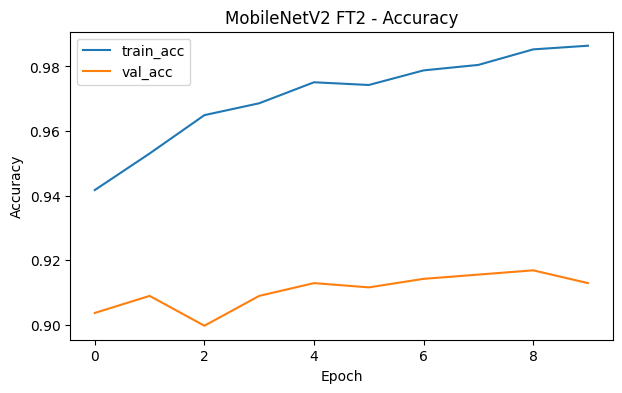

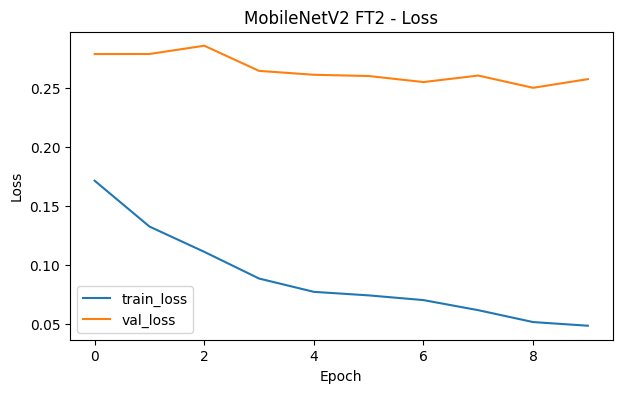

24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9089 - loss: 0.2717
MobileNetV2 FT2 - Test Loss: 0.2676096558570862
MobileNetV2 FT2 - Test Acc : 0.9182057976722717


In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(7,4))
plt.plot(hist_mnet_ft2.history["accuracy"], label="train_acc")
plt.plot(hist_mnet_ft2.history["val_accuracy"], label="val_acc")
plt.title("MobileNetV2 FT2 - Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(7,4))
plt.plot(hist_mnet_ft2.history["loss"], label="train_loss")
plt.plot(hist_mnet_ft2.history["val_loss"], label="val_loss")
plt.title("MobileNetV2 FT2 - Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss_ft2, test_acc_ft2 = mnet_model.evaluate(test_ds, verbose=1)
print("MobileNetV2 FT2 - Test Loss:", test_loss_ft2)
print("MobileNetV2 FT2 - Test Acc :", test_acc_ft2)

=== MobileNetV2 FT2 - Classification Report ===
              precision    recall  f1-score   support

       daisy     0.9500    0.8867    0.9172       150
   dandelion     0.9379    0.9557    0.9467       158
        rose     0.8758    0.8933    0.8845       150
   sunflower     0.9359    0.9733    0.9542       150
       tulip     0.8919    0.8800    0.8859       150

    accuracy                         0.9182       758
   macro avg     0.9183    0.9178    0.9177       758
weighted avg     0.9185    0.9182    0.9180       758



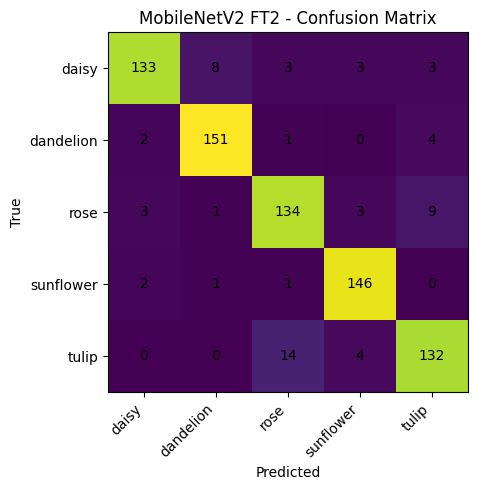

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_true, y_pred = [], []

for xb, yb in test_ds:
    probs = mnet_model.predict(xb, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(preds.tolist())

print("=== MobileNetV2 FT2 - Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("MobileNetV2 FT2 - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path
import json

SAVE_DIR = Path("/content/drive/MyDrive/uap_flowers_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

mnet_model.save(SAVE_DIR / "mobilenetv2_ft2.keras")

with open(SAVE_DIR / "class_names.json", "w") as f:
    json.dump(class_names, f)

with open(SAVE_DIR / "config.json", "w") as f:
    json.dump({"img_h": 224, "img_w": 224}, f)

print("Saved:", SAVE_DIR / "mobilenetv2_ft2.keras")

Saved: /content/drive/MyDrive/uap_flowers_models/mobilenetv2_ft2.keras
